In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=20,var1_u=60,CROP1=CROP,BATCH_SIZE=10)

2023-02-05 21:00:17.779350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-05 21:00:17.779371: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 21:00:17.779387: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-02-05 21:00:17.779594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

In [4]:
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return x

In [5]:
order = 1
num_classes = 20
input_shape = image_size + (1,)
it_lim = 1
gamma = 0.1

In [11]:
inputs = tf.keras.Input(shape=input_shape,name='input')
input_emb = tf.keras.layers.Input(shape = (1),name='input_emb')
emb = tf.keras.layers.Dense(num_classes*(order),activation='relu')(input_emb)
emb = tf.keras.layers.Dense(num_classes*(order),activation='relu')(emb)
emb_coef = tf.keras.layers.Reshape((num_classes,order),name='embedding')(emb)
emb_initial = tf.keras.layers.Dense(1,activation='relu')(emb)
x = classifier(inputs, num_classes=num_classes,CROP=CROP)

y = tf.keras.layers.Flatten(name='y')(x)

partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)

deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)

b_initial = tf.keras.layers.Dense(1,activation='relu')(y)
#b_initial = tf.keras.layers.add([b_initial,emb_initial])
a = tf.keras.layers.Dense(num_classes*order,activation = 'linear')(y)
a = tf.keras.layers.Reshape((num_classes,order))(a)
#a = tf.keras.layers.add([a,emb_coef])

b = (1/num_classes)*tf.ones_like(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


pm1 = -(2/num_classes)*np.power(np.linspace(0,1,num_classes+1),1)[:-1]
pm2 = np.exp(-np.power(np.linspace(0,1,num_classes+1),2)[:-1])
pm = np.multiply(pm1,pm2)
m = np.tril(np.ones((num_classes,num_classes)))
pm = np.multiply(m,pm)
pm = tf.constant(np.sum(pm,axis=-1))

ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs

for num_it in range(it_lim):


    difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
    difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
    deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])

    dS_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaS)
    dE_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaE)

    dS2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2),name=f'dx_{num_it}')(dS_n)
    dE2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dE_n)

    ineq1_S = tf.greater_equal(dS2, partition_low)
    ineq2_S = tf.less_equal(dS2,partition_up)
    ineq1_E = tf.greater_equal(dE2, partition_low)
    ineq2_E = tf.less_equal(dE2,partition_up)

    interval_S = tf.cast(tf.math.logical_and(ineq1_S,ineq2_S),tf.float32)
    interval_E = tf.cast(tf.math.logical_and(ineq1_E,ineq2_E),tf.float32)

    power_norm_S = tf.pow(dS2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_S = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_S)
    cte_S = tf.ones_like(inputs)
    power_norm_S = tf.keras.layers.Concatenate(axis=-1)((cte_S,power_norm_S))
    power_norm_S = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_S)
    power_norm_E = tf.pow(dE2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_E = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_E)
    cte_E = tf.ones_like(inputs)
    power_norm_E = tf.keras.layers.Concatenate(axis=-1)((cte_E,power_norm_E))
    power_norm_E = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_E)

    spline_S = tf.keras.layers.multiply([ct,power_norm_S])
    spline_S = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_S)
    spline_S = tf.keras.layers.Lambda(lambda z:tf.multiply(z[0],z[1]))([spline_S,pm])
    spline_S = tf.keras.layers.multiply([spline_S,interval_S])
    spline_E = tf.keras.layers.multiply([ct,power_norm_E])
    spline_E = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_E)
    spline_E = tf.keras.layers.Lambda(lambda z:tf.multiply(z[0],z[1]))([spline_E,pm])
    spline_E = tf.keras.layers.multiply([spline_E,interval_E])


    gS = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1)+1,name=f'gS_{num_it}')(spline_S)
    gS = tf.expand_dims(gS,axis=-1)
    gE = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1)+1,name=f'gE_{num_it}')(spline_E)
    gE = tf.expand_dims(gE,axis=-1)

    E = tf.keras.layers.multiply((gE,deltaE))
    S = tf.keras.layers.multiply((gS,deltaS))

    NS = S
    EW = E
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
    EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

    mult = gamma*tf.ones_like(NS)
    NS_mod = NS
    EW_mod = EW

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])

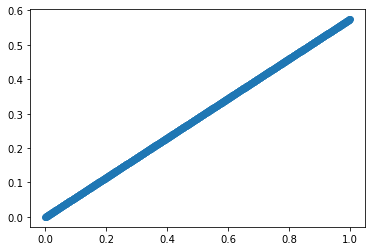

In [88]:
_ = np.random.choice(len(xs['input']))
x = np.linspace(0,1,1000)
co = np.concatenate([[np.squeeze(a[_][i]) for j in range(len(x)//num_classes)]for i in range(len(a[_]))])
ind = np.concatenate([[np.squeeze(b[_][i]) for j in range(len(x)//num_classes)]for i in range(len(b[_]))])
y = np.mod(x,1/num_classes)
plt.scatter(x,np.multiply(co,y)+ind)

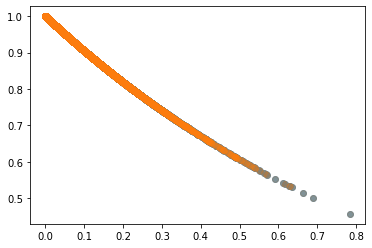

In [86]:
_ = np.random.choice(len(xs['input']))
axx = -np.log(np.ndarray.flatten(dE2[_].numpy()))
axy = np.ndarray.flatten(gE[_].numpy())
pm = np.exp(-np.ndarray.flatten(axx))
plt.scatter(axx,axy/np.mean(a[_]),alpha=0.75)
plt.scatter(axx,pm,alpha=0.25)

In [7]:
inputs = xs['input']
input_emb = xs['input_emb']

x = classifier(inputs, num_classes=num_classes,CROP=CROP)

y = tf.keras.layers.Flatten(name='y')(x)

partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
partition_low = tf.cast(partition_low,tf.float32)
partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
partition_up = tf.cast(partition_up,tf.float32)

deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)

b_initial = tf.keras.layers.Dense(1,activation='relu',
                                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0,stddev=1e-5))(y)
#b_initial = tf.keras.layers.add([b_initial,emb_initial])
a = tf.keras.layers.Dense(num_classes*order,activation = 'linear',
                         kernel_initializer=tf.keras.initializers.RandomNormal(mean=1,stddev=1e-5))(y)
a = tf.keras.layers.Reshape((num_classes,order))(a)
#a = tf.keras.layers.add([a,emb_coef])

b = (1/num_classes)*tf.ones_like(a)
b = tf.pow(b,np.arange(1,order+1))
b = tf.keras.layers.multiply([a,b])

m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
b = tf.keras.layers.Concatenate(axis=1)([b0,b])
b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
b = tf.keras.layers.add((b,b_initial))
b = tf.expand_dims(b,axis=-1)


ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

outputs = inputs

for num_it in range(it_lim):


    difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
    difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
    zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
    zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
    deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
    deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])

    dS_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaS)
    dE_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaE)

    dS2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2),name=f'dx_{num_it}')(dS_n)
    dE2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dE_n)
    dS2 = tf.keras.layers.Lambda(lambda z: tf.math.exp(-z))(dS2)
    dE2 = tf.keras.layers.Lambda(lambda z: tf.math.exp(-z))(dE2)

    ineq1_S = tf.greater_equal(dS2, partition_low)
    ineq2_S = tf.less_equal(dS2,partition_up)
    ineq1_E = tf.greater_equal(dE2, partition_low)
    ineq2_E = tf.less_equal(dE2,partition_up)

    interval_S = tf.cast(tf.math.logical_and(ineq1_S,ineq2_S),tf.float32)
    interval_E = tf.cast(tf.math.logical_and(ineq1_E,ineq2_E),tf.float32)

    power_norm_S = tf.pow(dS2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_S = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_S)
    cte_S = tf.ones_like(inputs)
    power_norm_S = tf.keras.layers.Concatenate(axis=-1)((cte_S,power_norm_S))
    power_norm_S = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_S)
    power_norm_E = tf.pow(dE2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
    power_norm_E = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_E)
    cte_E = tf.ones_like(inputs)
    power_norm_E = tf.keras.layers.Concatenate(axis=-1)((cte_E,power_norm_E))
    power_norm_E = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_E)

    spline_S = tf.keras.layers.multiply([ct,power_norm_S])
    spline_S = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_S)
    spline_S = tf.keras.layers.multiply([spline_S,interval_S])
    spline_E = tf.keras.layers.multiply([ct,power_norm_E])
    spline_E = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_E)
    spline_E = tf.keras.layers.multiply([spline_E,interval_E])


    gS = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gS_{num_it}')(spline_S)
    gS = tf.expand_dims(gS,axis=-1)
    gE = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gE_{num_it}')(spline_E)
    gE = tf.expand_dims(gE,axis=-1)

    E = tf.keras.layers.multiply((gE,deltaE))
    S = tf.keras.layers.multiply((gS,deltaS))

    NS = S
    EW = E
    NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
    EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
    NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
    EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

    mult = gamma*tf.ones_like(NS)
    NS_mod = NS
    EW_mod = EW

    adding = tf.keras.layers.add([NS,EW])
    adding = tf.keras.layers.multiply((mult,adding))

    outputs = tf.keras.layers.add([outputs,adding])
    
outputs = tf.keras.layers.Lambda(lambda z:tf.clip_by_value(z,0,1))(outputs)

tf.Tensor(44.68322, shape=(), dtype=float32)


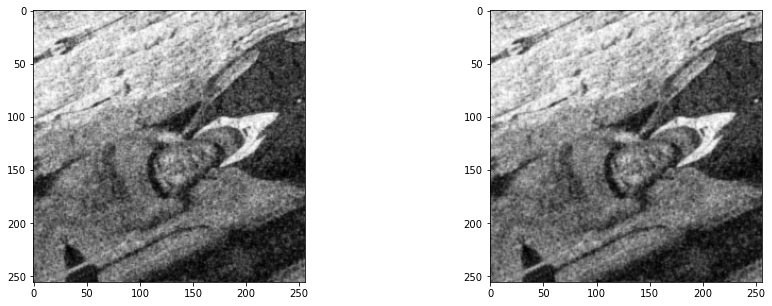

In [16]:
_ = np.random.choice(len(xs['input']))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(outputs[_],cmap='gray')
plt.subplot(122)
dn = anisodiff(xs['input'][_],niter=it_lim,lambd=1)
plt.imshow(dn,cmap='gray')
print(tf.image.psnr(dn,outputs[_],1))
plt.show()

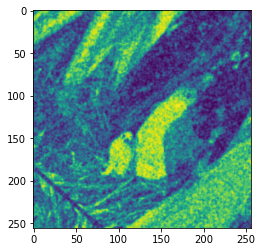

In [103]:
plt.imshow(anisodiff(xs['input'][_],niter=it_lim,lambd=1))

# Decreasing

In [2]:
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return x

In [ ]:
def decreasing(input_shape, it_lim = 1,num_classes=10,CROP=256):

    inputs = tf.keras.Input(shape=input_shape,name='input')
    input_emb = tf.keras.layers.Input(shape = (1),name='input_emb')

    x = classifier(inputs, num_classes=num_classes,CROP=CROP)

    y = tf.keras.layers.Flatten(name='y')(x)

    partition_low = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[:-1])
    partition_low = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_low,0),0),0)
    partition_low = tf.cast(partition_low,tf.float32)
    partition_up = tf.constant(np.power(np.linspace(0,1,num_classes+1),1)[1:])
    partition_up = tf.expand_dims(tf.expand_dims(tf.expand_dims(partition_up,0),0),0)
    partition_up = tf.cast(partition_up,tf.float32)

    deltaS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    deltaE = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    NS = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    EW = tf.keras.layers.Lambda(lambda z:tf.zeros_like(z))(inputs)
    gS = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)
    gE = tf.keras.layers.Lambda(lambda z:tf.ones_like(z))(inputs)

    b_initial = tf.keras.layers.Dense(1,activation='relu')(y)
    a = tf.keras.layers.Dense(num_classes*order,activation = 'relu')(y)
    a = tf.keras.layers.Reshape((num_classes,order))(a)
    a = tf.keras.layers.Lambda(lambda z:-z)(a)
    
    b = (1/num_classes)*tf.ones_like(a)
    b = tf.pow(b,np.arange(1,order+1))
    b = tf.keras.layers.multiply([a,b])

    m = tf.linalg.LinearOperatorLowerTriangular(tf.ones(tf.shape(a)+(0,0,num_classes-1))).to_dense()
    b = tf.keras.layers.multiply([tf.transpose(b,perm=(0,2,1)),m])
    b = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(b)
    b0 = tf.keras.layers.Lambda(lambda z:tf.expand_dims(tf.zeros_like(z[:,0]),axis=-1))(b)
    b = tf.keras.layers.Concatenate(axis=1)([b0,b])
    b = tf.keras.layers.Lambda(lambda z:z[:,:-1])(b)
    b = tf.keras.layers.add((b,b_initial))
    b = tf.expand_dims(b,axis=-1)


    ct = tf.keras.layers.Concatenate(name='coeff_spline')((b,a))
    ct = tf.keras.layers.Lambda(lambda z: tf.expand_dims(tf.expand_dims(z,axis=1),axis=1))(ct)

    outputs = inputs

    for num_it in range(it_lim):


        difS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(outputs)
        difE = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(outputs)
        zeros_y = tf.expand_dims(tf.zeros_like(outputs)[:,1],axis=-1)
        zeros_x = tf.expand_dims(tf.zeros_like(inputs)[:,1],axis=-3)
        deltaS = tf.keras.layers.Concatenate(axis=1)([difS,zeros_x])
        deltaE = tf.keras.layers.Concatenate(axis=2)([difE,zeros_y])

        dS_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaS)
        dE_n = tf.keras.layers.Lambda(lambda z: tf.math.abs(z)/tf.reduce_max(tf.math.abs(z)))(deltaE)

        dS2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2),name=f'dx_{num_it}')(dS_n)
        dE2 = tf.keras.layers.Lambda(lambda z:tf.math.pow(z,2))(dE_n)

        ineq1_S = tf.greater_equal(dS2, partition_low)
        ineq2_S = tf.less_equal(dS2,partition_up)
        ineq1_E = tf.greater_equal(dE2, partition_low)
        ineq2_E = tf.less_equal(dE2,partition_up)

        interval_S = tf.cast(tf.math.logical_and(ineq1_S,ineq2_S),tf.float32)
        interval_E = tf.cast(tf.math.logical_and(ineq1_E,ineq2_E),tf.float32)

        power_norm_S = tf.pow(dS2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
        power_norm_S = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_S)
        cte_S = tf.ones_like(inputs)
        power_norm_S = tf.keras.layers.Concatenate(axis=-1)((cte_S,power_norm_S))
        power_norm_S = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_S)
        power_norm_E = tf.pow(dE2,tf.constant(np.asarray(np.arange(1,order+1),dtype='float32')))
        power_norm_E = tf.keras.layers.Lambda(lambda z:tf.math.mod(z,1/num_classes))(power_norm_E)
        cte_E = tf.ones_like(inputs)
        power_norm_E = tf.keras.layers.Concatenate(axis=-1)((cte_E,power_norm_E))
        power_norm_E = tf.keras.layers.Lambda(lambda z: tf.expand_dims(z,axis=-2))(power_norm_E)

        spline_S = tf.keras.layers.multiply([ct,power_norm_S])
        spline_S = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_S)
        spline_S = tf.keras.layers.multiply([spline_S,interval_S])
        spline_E = tf.keras.layers.multiply([ct,power_norm_E])
        spline_E = tf.keras.layers.Lambda(lambda z:tf.math.reduce_sum(z,axis=-1))(spline_E)
        spline_E = tf.keras.layers.multiply([spline_E,interval_E])


        gS = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gS_{num_it}')(spline_S)
        gS = tf.expand_dims(gS,axis=-1)
        gE = tf.keras.layers.Lambda(lambda z: tf.math.reduce_sum(z,axis=-1),name=f'gE_{num_it}')(spline_E)
        gE = tf.expand_dims(gE,axis=-1)

        E = tf.keras.layers.multiply((gE,deltaE))
        S = tf.keras.layers.multiply((gS,deltaS))

        NS = S
        EW = E
        NS = tf.keras.layers.Concatenate(axis=1)([zeros_x,NS])
        EW = tf.keras.layers.Concatenate(axis=2)([zeros_y,EW])
        NS = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=1))(NS)
        EW = tf.keras.layers.Lambda(lambda z: tf.experimental.numpy.diff(z,axis=2))(EW)

        mult = gamma*tf.ones_like(NS)
        NS_mod = NS
        EW_mod = EW

        adding = tf.keras.layers.add([NS,EW])
        adding = tf.keras.layers.multiply((mult,adding))

        outputs = tf.keras.layers.add([outputs,adding])
        
        
    return tf.keras.models.Model([inputs,input_emb], outputs)